In [97]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [98]:
houses_data = pd.read_csv('./houses_train.csv')
print(houses_data.shape)   # (rows, cols)
houses_data.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [99]:
houses_data.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

可以看到81个特征中，38个是数字，其他43个为'object' (大部分应该是字符，我们随后看看)

In [100]:
houses_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [101]:
def show_missing():
    missing_value_index = houses_data.columns[houses_data.isnull().any()].tolist()
    return houses_data[missing_value_index].isnull().sum()
show_missing()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

缺失值的列表.  下面我们看看怎么逐个填充缺失值.

### LotFrontage  

文档中的解释 LotFrontage: Linear feet of street connected to property.  与街道接壤的长度. 我们同时注意到原数据有一列 LotArea 代表房屋面积是没有缺失值的. 或许我们能从两者关系上入手填充这部分数据？


In [102]:
houses_data['LotFrontage'].corr(houses_data['LotArea'])

0.42609501877180816

.42 似乎并不高，我们再来仔细想想. LotArea代表占地面积，我们假设大部分房屋占地都是正/长方形的话，面积的开方很可能会接近长度. 

In [103]:
houses_data['Sqrt_LotArea'] = np.sqrt(houses_data['LotArea'])
houses_data['Sqrt_LotArea'].corr(houses_data['LotFrontage'])

0.60200221679393628

In [104]:
null_Frontage_index = houses_data['LotFrontage'].isnull()
houses_data['LotFrontage'][null_Frontage_index] = houses_data['Sqrt_LotArea'][null_Frontage_index]
del houses_data['Sqrt_LotArea']

### Alley

文档中已然说明Alley只有三种取值，Grvl Pave NA。   NA代表no alley access，所以这里我们直接把空值置为None

In [105]:
houses_data['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [106]:
houses_data['Alley'][houses_data['Alley'].isnull()]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
31      NaN
       ... 
1428    NaN
1429    NaN
1430    NaN
1431    NaN
1433    NaN
1434    NaN
1435    NaN
1436    NaN
1437    NaN
1438    NaN
1439    NaN
1440    NaN
1441    NaN
1442    NaN
1443    NaN
1444    NaN
1445    NaN
1446    NaN
1447    NaN
1448    NaN
1449    NaN
1450    NaN
1451    NaN
1452    NaN
1453    NaN
1455    NaN
1456    NaN
1457    NaN
1458    NaN
1459    NaN
Name: Alley, dtype: object

In [107]:
houses_data['Alley'].fillna('None', inplace=True)

###  MasVnrType & MasVnrArea

这两个值我们放到一起来看. ‘Masonry veneer’表层砌体是在建筑墙外部额外的一层表皮. 文档中说明了存在None值，我们来看看一共有多少建筑时没有Masonry veneer的：

In [108]:
houses_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

1460条数据中，已知有864个是没有Masonry veneer的，那么这些数据行的MasVnrArea值是什么呢？是0么？

In [109]:
houses_data['MasVnrArea'][houses_data['MasVnrType'] == 'None'].value_counts()

0.0      859
1.0        2
312.0      1
344.0      1
288.0      1
Name: MasVnrArea, dtype: int64

我们发现大部分符合我们的判断. 我们可以将空值全部填充None，相应MasVnrArea填0. 有5条脏数据，我们统一把它们化为0.

In [110]:
houses_data['MasVnrType'][houses_data['MasVnrType'].isnull()].fillna('None', inplace=True)
houses_data['MasVnrArea'][houses_data['MasVnrType'] == 'None'] = 0.0

In [111]:
show_missing()

MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Bsmt  

这一系列数据全部跟地下室有关. 值得注意的是 BsmtFinSF1 和 BsmtFinSF2 这两列没有缺失数据. 文档中提到若BsmtQual若为空值，则表示没有地下室. 我们看一下BsmtQual为空时，BsmtFinSF1 和 BsmtFinSF2 以及其他Bsmt数据

In [112]:
basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
houses_data[['BsmtFinSF1', 'BsmtFinSF2']+basement_cols][houses_data['BsmtQual'].isnull()]

,BsmtFinSF1,BsmtFinSF2,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
17,0,0,NaN,NaN,NaN,NaN,NaN
39,0,0,NaN,NaN,NaN,NaN,NaN
90,0,0,NaN,NaN,NaN,NaN,NaN
102,0,0,NaN,NaN,NaN,NaN,NaN
156,0,0,NaN,NaN,NaN,NaN,NaN
182,0,0,NaN,NaN,NaN,NaN,NaN
259,0,0,NaN,NaN,NaN,NaN,NaN
342,0,0,NaN,NaN,NaN,NaN,NaN
362,0,0,NaN,NaN,NaN,NaN,NaN
371,0,0,NaN,NaN,NaN,NaN,NaN


的确，当类型数据值为空时，数字数据一样为空，也就是说没有地下室. 所以Bsmt系列的缺失值全可填充为None

In [113]:
for col in basement_cols:
    houses_data[col].fillna('None', inplace=True)

### Electrical
这列只有一个缺失值. 我们先看看其他值的分布.

In [114]:
houses_data['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

SBrkr占比超过90%，就把它填充上去吧

In [115]:
houses_data['Electrical'].fillna('SBrkr', inplace=True)

### FireplaceQu

类似地，FireplaceQu（火炉质量）有690个缺失值而Fireplaces（火炉个数）没有缺失值. 很可能缺失部分为没有火炉. 我们看一下

In [116]:
houses_data['Fireplaces'][houses_data['FireplaceQu'].isnull()].value_counts()

0    690
Name: Fireplaces, dtype: int64

In [117]:
houses_data['FireplaceQu'].fillna('None', inplace=True)

### Garages

这部分的探索和处理跟Bsmt一模一样.

In [118]:
garage_cols = ['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish']

for cols in garage_cols:
    if houses_data[cols].dtype == np.object:
        houses_data[cols].fillna('None', inplace=True)
    else:
        houses_data[cols].fillna(0, inplace=True)         

### PoolQC

同样地，PoolQC(质量)有缺失值而PoolArea(面积)没有

In [119]:
houses_data['PoolArea'][houses_data['PoolQC'].isnull()].value_counts()

0    1453
Name: PoolArea, dtype: int64

In [120]:
houses_data['PoolQC'].fillna('None', inplace=True)

### Fence, MiscFeature

这两列都没有其他相关列来进行分析，故参考文档中空值全部填充为None. 表示没有这些特性.

In [121]:
houses_data['Fence'].fillna('None', inplace=True)
houses_data['MiscFeature'].fillna('None', inplace=True)

完成了，数据集已经没有缺失值了.

## 现在来看看任务的目标 SalePrice

In [123]:
houses_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

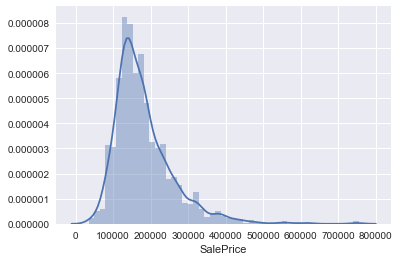

In [124]:
sns.distplot(houses_data['SalePrice'])

可以观察到: 1. 并不是正态分布 2. 存在正偏度 3. 有峰值

In [125]:
print('偏度: %f' % houses_data['SalePrice'].skew())
print('峰度：%f' % houses_data['SalePrice'].kurt())

偏度: 1.882876
峰度：6.536282


### 与各种特征的关系系数

In [126]:
corr=houses_data.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)]

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
GarageYrBlt      0.261366
LotArea          0.263843
HalfBath         0.284108
LotFrontage      0.286676
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.478328
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

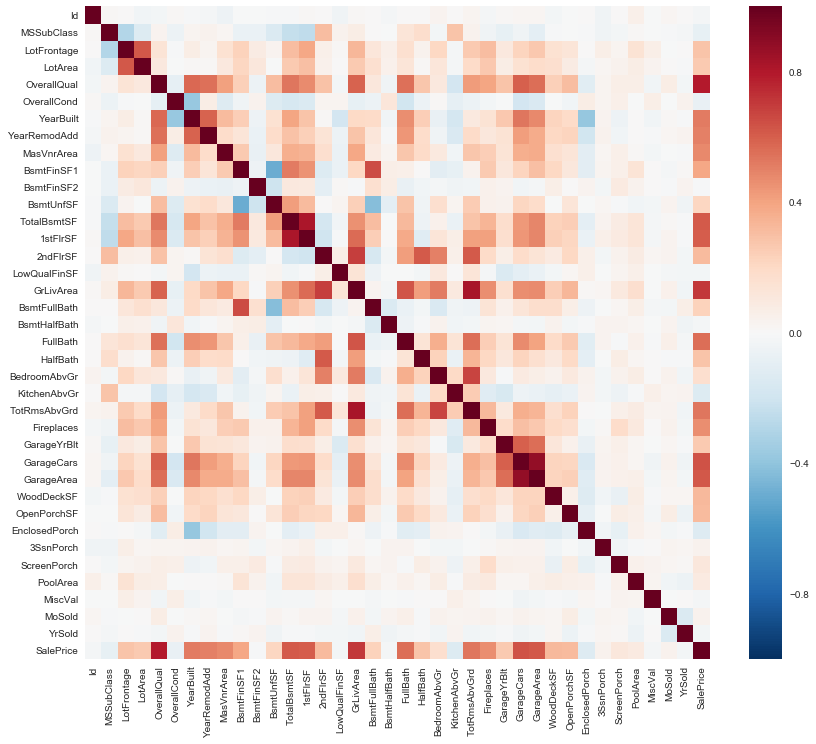

In [127]:
f, ax = plt.subplots(figsize = (14, 12))
sns.heatmap(houses_data.corr())

可以看到几组联系非常强的特征比如TotalBsmtSF和1stFirSF,GarageCars和GarageArea. 从文档中也能看出逻辑（车库的面积和车库可存放车辆数）我们可以选择只保留其中一列.

### 与部分数字特征的关系

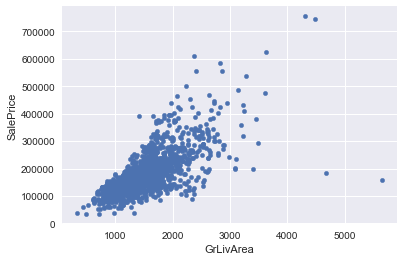

In [128]:
houses_data[['GrLivArea', 'SalePrice']].plot.scatter(x='GrLivArea', y='SalePrice')

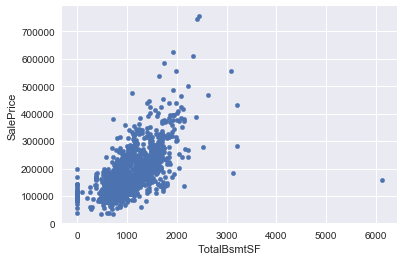

In [129]:
houses_data[['TotalBsmtSF', 'SalePrice']].plot.scatter(x='TotalBsmtSF', y='SalePrice')

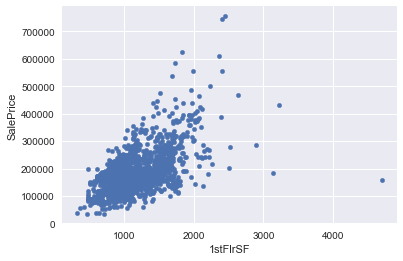

In [130]:
houses_data[['1stFlrSF', 'SalePrice']].plot.scatter(x='1stFlrSF', y='SalePrice')

可以看出这几个变量与saleprice几乎呈线性关系.

### 与分类特征的关系

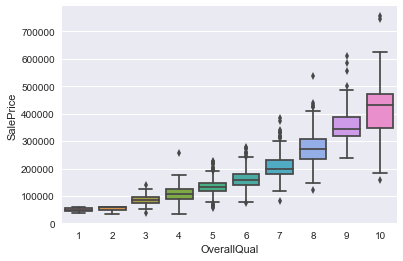

In [131]:
sns.boxplot(x='OverallQual', y='SalePrice', data=houses_data[['OverallQual','SalePrice']])

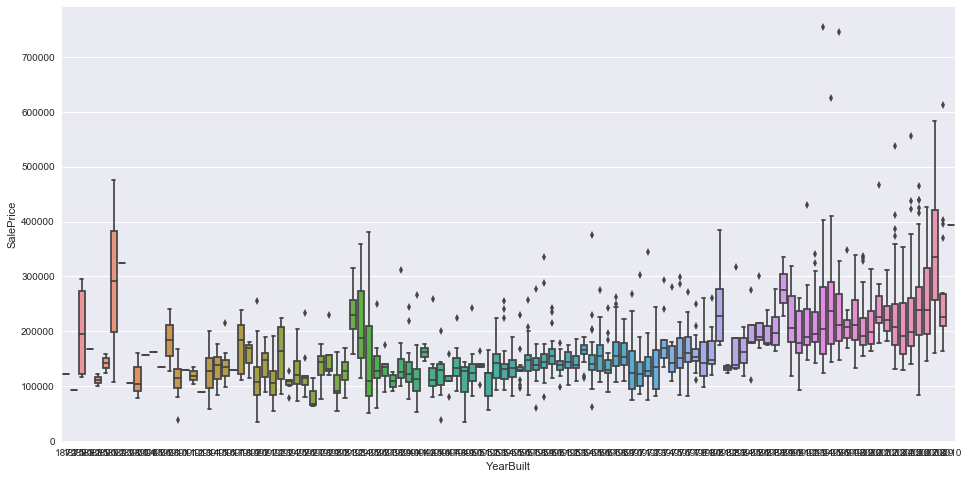

In [132]:
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=houses_data[['YearBuilt', 'SalePrice']], x='YearBuilt', y='SalePrice')

能看到房价与年份的新旧不像最初想的那样有很强的联系.

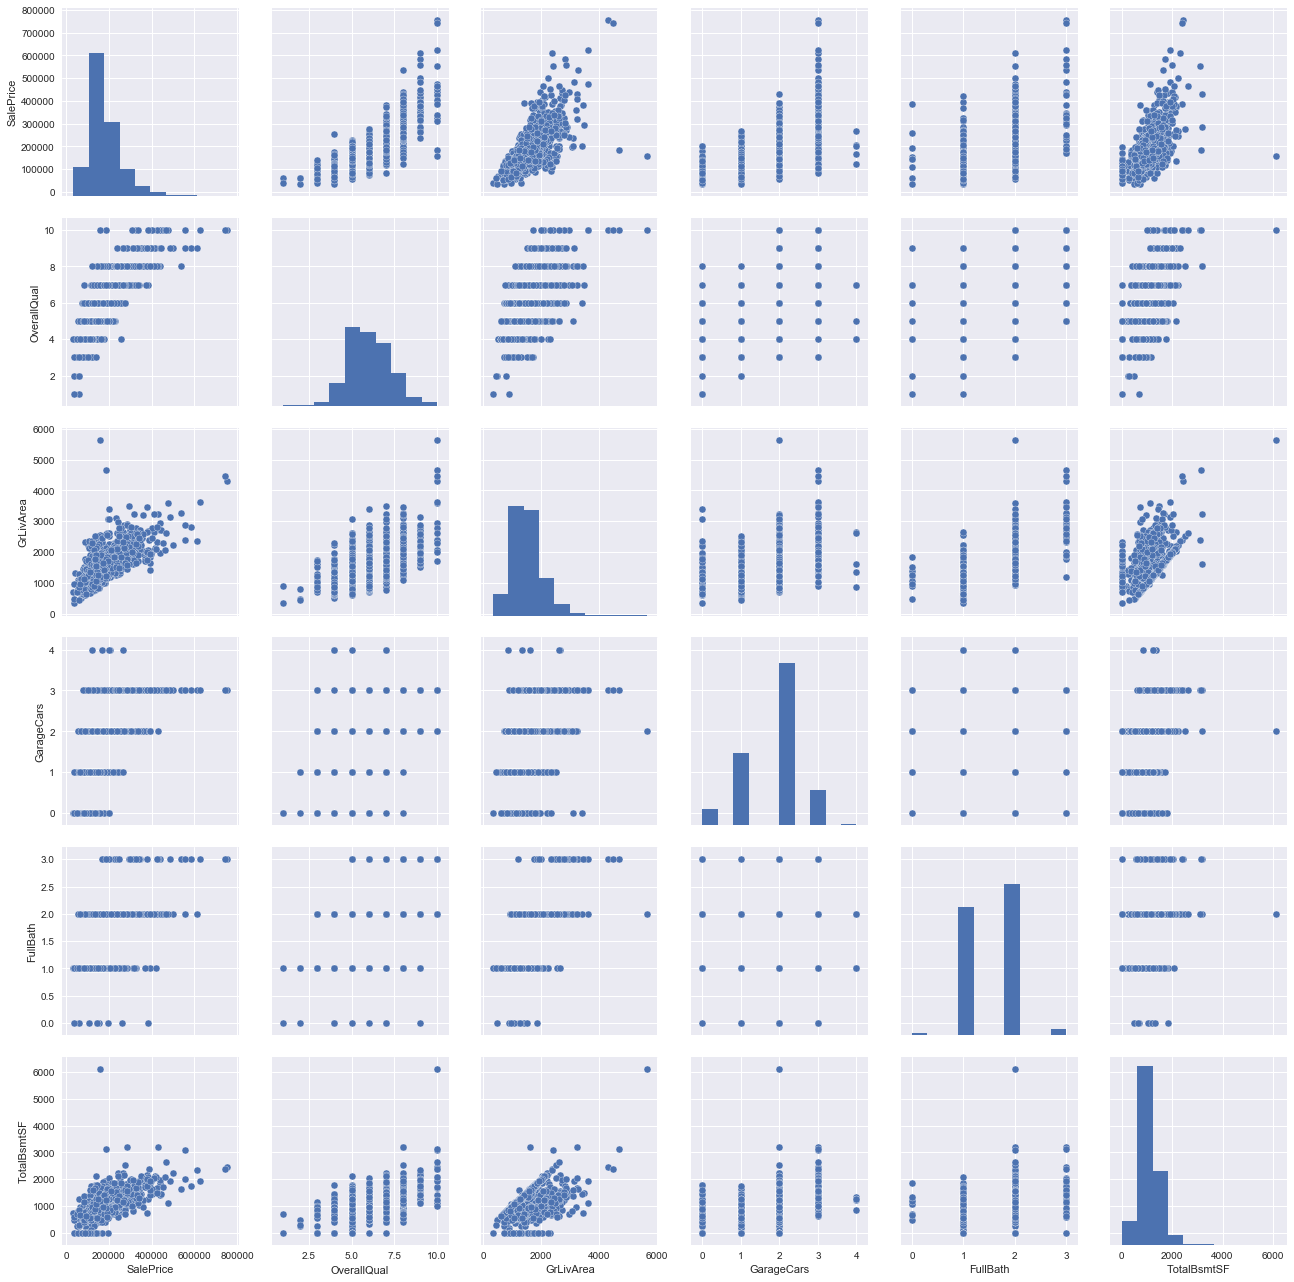

In [133]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'TotalBsmtSF']
sns.pairplot(houses_data[cols], size = 3)

### 异常值

最大的问题是我们怎样判断一个值是否是异常值，在什么范围外算异常值. 我们需要将数据标准化，这里标准化意为使数据平均值为0，标准差为1.

In [134]:
scaled_saleprice = StandardScaler().fit_transform(houses_data['SalePrice'])
scaled_saleprice.sort()
print('最小的10个值：')
print(scaled_saleprice[:10])
print('最大的10个值：')
print(scaled_saleprice[-10:])

最小的10个值：
[-1.83870376 -1.83352844 -1.80092766 -1.78329881 -1.77448439 -1.62337999
 -1.61708398 -1.58560389 -1.58560389 -1.5731    ]
最大的10个值：
[ 3.82897043  4.04098249  4.49634819  4.71041276  4.73032076  5.06214602
  5.42383959  5.59185509  7.10289909  7.22881942]


能看出最小值差别不大，而且都比较接近0. 最大值已经超出0非常多， 甚至有两个7.的数据. 我们应该着重关注下这几个点

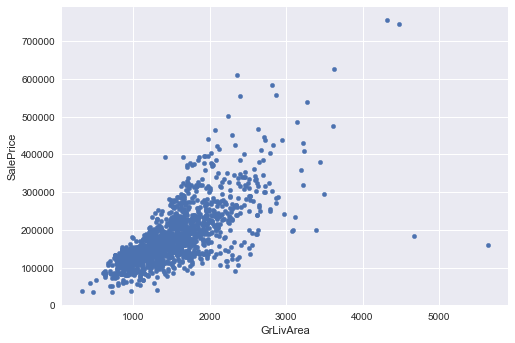

In [135]:
houses_data[['SalePrice', 'GrLivArea']].plot.scatter(x='GrLivArea', y='SalePrice')

这副图里又几个点比较特殊. 右下角这两个点，面积非常大但是价格很低，这是非常特殊的情况（地理位置偏远），我们考虑将这两个点删掉. 而相对地右上角的两个点，虽然离群很远但是基本满足数据趋势，所以我们保留这两个点.

In [136]:
houses_data.sort_values(by = 'GrLivArea', ascending = False)[:2]   #找到两个异常点

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,...,480,Gd,None,None,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,...,0,None,None,None,0,10,2007,New,Partial,184750


In [137]:
houses_data = houses_data.drop(1298)    #删除
houses_data = houses_data.drop(523)

### Normality

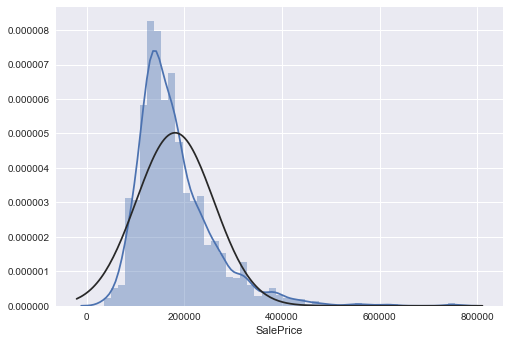

In [138]:
sns.distplot(houses_data['SalePrice'], fit = norm)

SalePrice与正态分布的比较

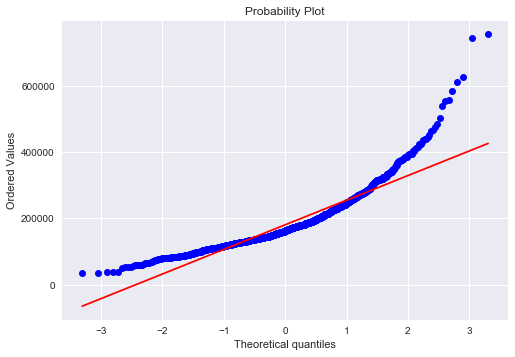

In [139]:
prob = stats.probplot(houses_data['SalePrice'], plot = plt)

SalePrice的概率图与正太概率图的比较. 可以看出SalePrice不是正态分布，而数据满足正态分布对许多统计学测试来说非常重要，所以我们尝试讲它转换成正态分布. 对于有正偏度的数据，取log可以解决这个问题.

In [140]:
houses_data['SalePrice'] = np.log(houses_data['SalePrice'])

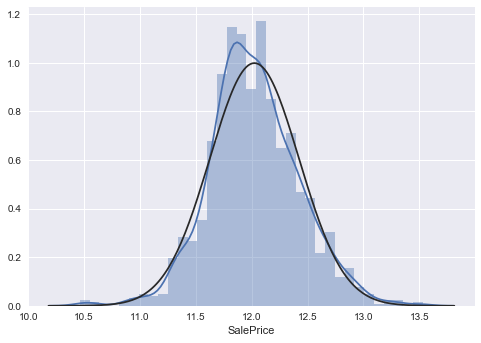

In [141]:
sns.distplot(houses_data['SalePrice'], fit = norm)

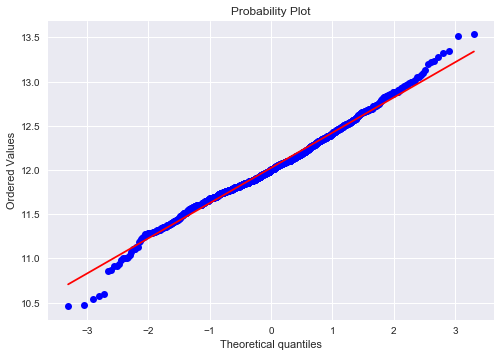

In [142]:
prob = stats.probplot(houses_data['SalePrice'], plot = plt)

已经解决正态分布问题.

In [143]:
houses_data = pd.get_dummies(houses_data)

最后将其他分类数据转换成dummy variables